In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

CONTEXT_DATASET = "../data/Chart-24/mutants.context"
KILL_DATASET = "../data/Chart-24/kill.csv"

context_dataset = pd.read_csv(CONTEXT_DATASET)
kill_dataset = pd.read_csv(KILL_DATASET)

del context_dataset['mutationOperatorGroup']
del context_dataset['nodeTypeDetailed']
del context_dataset['nodeContextBasic']
del context_dataset['astContextDetailed']
del context_dataset['parentContextBasic']
del context_dataset['parentContextDetailed']
del context_dataset['parentStmtContextBasic']
del context_dataset['parentStmtContextDetailed']


context_dataset


,mutantNo,mutationOperator,nodeTypeBasic,astContextBasic,hasLiteralChild,hasVariableChild,hasOperatorChild
0,1,DOUBLE_LITERAL:DOUBLE_LITERAL,DOUBLE,METHOD_INVOCATION;METHOD_INVOCATION;BLOCK;METH...,0,0,0
1,2,DOUBLE_LITERAL:DOUBLE_LITERAL,DOUBLE,METHOD_INVOCATION;METHOD_INVOCATION;BLOCK;METH...,0,0,0
2,3,DOUBLE_LITERAL:DOUBLE_LITERAL,DOUBLE,METHOD_INVOCATION;METHOD_INVOCATION;BLOCK;METH...,0,0,0
3,4,DOUBLE_LITERAL:DOUBLE_LITERAL,DOUBLE,METHOD_INVOCATION;METHOD_INVOCATION;BLOCK;METH...,0,0,0
4,5,GREATER_THAN_EQUAL:EQUAL_TO,BOOLEAN,PARENTHESIZED;IF;BLOCK;METHOD;CLASS,0,1,0
5,6,GREATER_THAN_EQUAL:GREATER_THAN,BOOLEAN,PARENTHESIZED;IF;BLOCK;METHOD;CLASS,0,1,0
6,7,GREATER_THAN_EQUAL:TRUE,BOOLEAN,PARENTHESIZED;IF;BLOCK;METHOD;CLASS,0,1,0
7,8,<ASSIGN>:<NO-OP>,null,BLOCK;METHOD;CLASS,0,0,0
8,9,<ASSIGN>:<NO-OP>,null,BLOCK;METHOD;CLASS,0,0,0
9,10,<ASSIGN>:<NO-OP>,null,BLOCK;METHOD;CLASS,0,0,0


In [8]:
from sklearn import tree
import numpy as np

vectorizer_ast = CountVectorizer(ngram_range=(1,4), analyzer='word')
ast_vectorized = vectorizer_ast.fit_transform(context_dataset['astContextBasic'])

vectorizer_mutation_op= CountVectorizer()
mutation_op_vectorized = vectorizer_mutation_op.fit_transform(context_dataset['mutationOperator'])

vectorizer_node_type= CountVectorizer()
node_type_vectorized = vectorizer_node_type.fit_transform(context_dataset['nodeTypeBasic'])

ast_df = pd.DataFrame(ast_vectorized.A, columns=vectorizer_ast.get_feature_names())
mutation_op_df = pd.DataFrame(mutation_op_vectorized.A, columns=vectorizer_mutation_op.get_feature_names())
node_type_df = pd.DataFrame(node_type_vectorized.A, columns=vectorizer_node_type.get_feature_names())

X_train = ast_df.add_prefix('ast_')
X_train = X_train.join(mutation_op_df.add_prefix('mop_'))
X_train = X_train.join(node_type_df.add_prefix('nty_'))
X_train = X_train.join(context_dataset['hasLiteralChild'])
X_train = X_train.join(context_dataset['hasVariableChild'])
X_train = X_train.join(context_dataset['hasOperatorChild'])

X_train

,ast_block,ast_block if,ast_block if block,ast_block if block method,ast_block method,ast_block method class,ast_class,ast_divide,ast_divide multiply,ast_divide multiply parenthesized,...,mop_op,mop_plus,mop_remainder,mop_true,nty_boolean,nty_double,nty_null,hasLiteralChild,hasVariableChild,hasOperatorChild
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
7,1,0,0,0,1,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
8,1,0,0,0,1,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
9,1,0,0,0,1,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [9]:
status_to_nonequivalent = {
    'FAIL': 'NON_EQUIVALENT',
    'TIME': 'NON_EQUIVALENT',
    'EXC': 'NON_EQUIVALENT',
    'LIVE': 'MAYBE_EQUIVALENT'
}

kill_dataset['non_equivalent'] = kill_dataset['[FAIL | TIME | EXC | LIVE]'].str.upper().map(status_to_nonequivalent)

y_train = kill_dataset['non_equivalent']

kill_dataset

,MutantNo,[FAIL | TIME | EXC | LIVE],non_equivalent
0,1,EXC,NON_EQUIVALENT
1,2,FAIL,NON_EQUIVALENT
2,3,EXC,NON_EQUIVALENT
3,4,EXC,NON_EQUIVALENT
4,5,LIVE,MAYBE_EQUIVALENT
5,6,LIVE,MAYBE_EQUIVALENT
6,7,EXC,NON_EQUIVALENT
7,8,FAIL,NON_EQUIVALENT
8,9,FAIL,NON_EQUIVALENT
9,10,EXC,NON_EQUIVALENT


In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

clf = clf.fit(X_train, y_train)

In [11]:
from sklearn import metrics

def measure_performance(X, y, clf):
    y_pred = clf.predict(X)
    print("Accuracy: %f \n" % metrics.accuracy_score(y, y_pred))
    print(metrics.classification_report(y, y_pred), "\n")

measure_performance(X_train, y_train, clf)
    
    

Accuracy: 0.950000 

                  precision    recall  f1-score   support

MAYBE_EQUIVALENT       0.88      0.88      0.88         8
  NON_EQUIVALENT       0.97      0.97      0.97        32

     avg / total       0.95      0.95      0.95        40
 



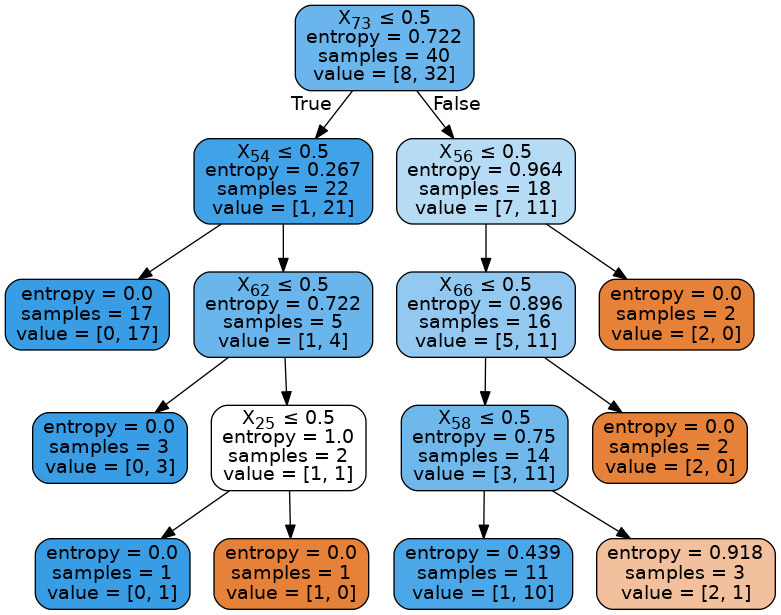

In [12]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())
